In [1]:
import numpy as np
import cv2
import skimage.io 
import skimage.color
#Import necessary functions
from planarH import computeH_ransac, computeH_ransac_adaptive, warped, compositeH, computeH_norm
from matchPics import matchPics
from matplotlib import pyplot as plt

In [2]:
def loadVid(filename):
    cap = cv2.VideoCapture(filename)
    fps = cap.get(cv2.CAP_PROP_FPS)
    print(fps)
    frames = [] 
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()

    return frames

In [3]:
cv_cover = cv2.imread('../data/cv_cover.jpg') # (440, 350, 3)
book_frames = loadVid("../data/book.mov") # (480, 640) 641 frame
ar_frames = loadVid("../data/ar_source.mov") # (360, 640) 511 frame

30.0
25.0


In [ ]:
np.ones_like()

In [4]:
print(len(book_frames))
print(len(ar_frames))

641
511


### Test

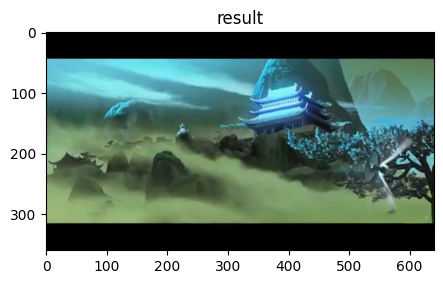

In [5]:
plt.figure(figsize=(5, 5))
plt.imshow(ar_frames[0])
plt.title('result')
plt.show()

In [6]:
cropped_ar = ar_frames[0][44:316, 320 - 108 : 320 + 108]

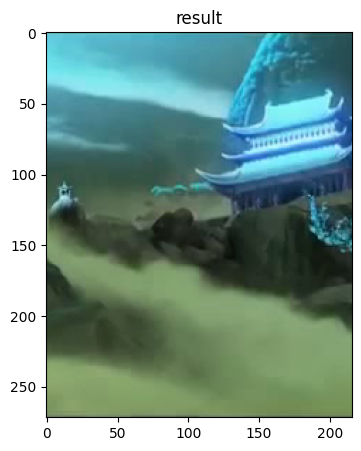

In [7]:
plt.figure(figsize=(5, 5))
plt.imshow(cropped_ar)
plt.title('result')
plt.show()

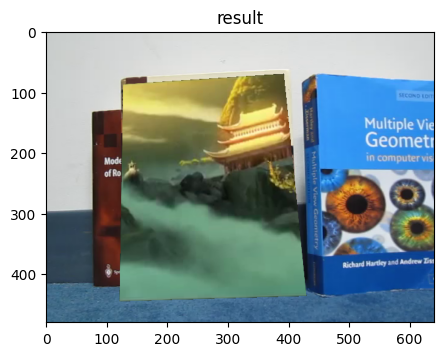

In [8]:
orb = cv2.ORB_create()

kp1, des1 = orb.detectAndCompute(cv_cover, None)
kp2, des2 = orb.detectAndCompute(book_frames[0], None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

matches_cv = bf.match(des1, des2)

pts1 = np.float32([kp1[m.queryIdx].pt for m in matches_cv]).reshape(-1, 2)
pts2 = np.float32([kp2[m.trainIdx].pt for m in matches_cv]).reshape(-1, 2)

# Sort matches by distance
matches_cv = sorted(matches_cv, key=lambda x: x.distance)

num_matches_60 = int(len(matches_cv) * 0.3)  # choose 10% of total matches
best_matches_60 = matches_cv[:num_matches_60]

pts1_best_60 = np.float32([kp1[m.queryIdx].pt for m in best_matches_60]).reshape(-1, 2)
pts2_best_60 = np.float32([kp2[m.trainIdx].pt for m in best_matches_60]).reshape(-1, 2)

H2to1, _ = computeH_ransac_adaptive(pts2_best_60, pts1_best_60, 100)

h, w = book_frames[0].shape[:2]

cropped_ar = cv2.resize(cropped_ar, dsize=(cv_cover.shape[1], cv_cover.shape[0]), interpolation=cv2.INTER_AREA)

warped_cropped_ar = cv2.warpPerspective(cropped_ar, H2to1, (w, h))
warped_cropped_ar = cv2.cvtColor(warped_cropped_ar, cv2.COLOR_BGR2RGB)

result = warped(H2to1, cropped_ar, book_frames[0])
result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(5, 5))
plt.imshow(result)
plt.title('result')
plt.show()

## Code

In [10]:
# Create output video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('../result/ar.mp4', fourcc, 25, (480, 640))

for book_frame, ar_frame in zip(book_frames, ar_frames):

    cropped_ar = ar_frame[44:316, 320-108 : 320+108]

    orb = cv2.ORB_create(nfeatures=40000,
    scaleFactor=1.2,
    nlevels=8,
    edgeThreshold=31,
    firstLevel=0,
    WTA_K=2,
    scoreType=cv2.ORB_HARRIS_SCORE,
    patchSize=31,
    fastThreshold=20)

    kp1, des1 = orb.detectAndCompute(cv_cover, None)
    kp2, des2 = orb.detectAndCompute(book_frame, None)

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    matches_cv = bf.match(des1, des2)

    # Sort matches by distance
    matches_cv = sorted(matches_cv, key=lambda x: x.distance)

    num_matches = int(len(matches_cv) * 0.5)  # choose 10% of total matches
    best_matches = matches_cv[:num_matches]

    pts1_best = np.float32([kp1[m.queryIdx].pt for m in best_matches]).reshape(-1, 2)
    pts2_best = np.float32([kp2[m.trainIdx].pt for m in best_matches]).reshape(-1, 2)

    H2to1, inliers = computeH_ransac_adaptive(pts2_best, pts1_best, 300, 2)
    
    H2to1 = computeH_norm(pts2_best[inliers], pts1_best[inliers])
    
    h, w = book_frames[0].shape[:2]

    cropped_ar = cv2.resize(cropped_ar, dsize=(cv_cover.shape[1], cv_cover.shape[0]), interpolation=cv2.INTER_AREA)

    warped_cropped_ar = cv2.warpPerspective(cropped_ar, H2to1, (w, h))

    result = warped(H2to1, cropped_ar, book_frame)

    # Resize result frame to fit onto output video frame
    #result_frame = cv2.resize(result, (640, 480))

    # Write result frame to output video
    out.write(result)

    # Display result frame
    cv2.imshow("AR", result)
    cv2.waitKey(1)

out.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 